Text(0.5, 0, 'x (km)')

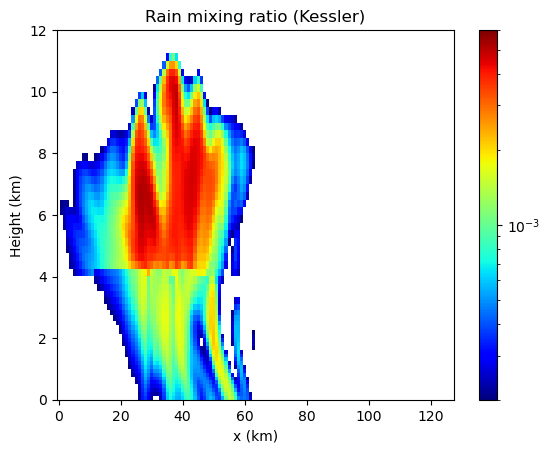

In [31]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Open the CM1 output file
with nc.Dataset('outputMorrison/cm1out.nc') as f:
    z=f.variables['zh'][:]
    qtot = f.variables['qr'][:]+f.variables['qc'][:]+f.variables['qs'][:]+f.variables['qi'][:]+f.variables['qg'][:]
    qliq = f.variables['qr'][:]+f.variables['qc'][:]
    
with nc.Dataset('cm1out.nc') as f:
    z=f.variables['zh'][:]
    qrk = f.variables['qr'][:]+f.variables['qs'][:]
    
qrkm=np.ma.array(qrk,mask=qrk<0.0002)
plt.title('Rain mixing ratio (Kessler)')
plt.pcolormesh(range(128),z,qrkm[-2,:,10,:],cmap='jet',norm=matplotlib.colors.LogNorm(vmin=0.0002,vmax=0.006))
plt.colorbar()
plt.ylim(0,12)
plt.ylabel('Height (km)')
plt.xlabel('x (km)')

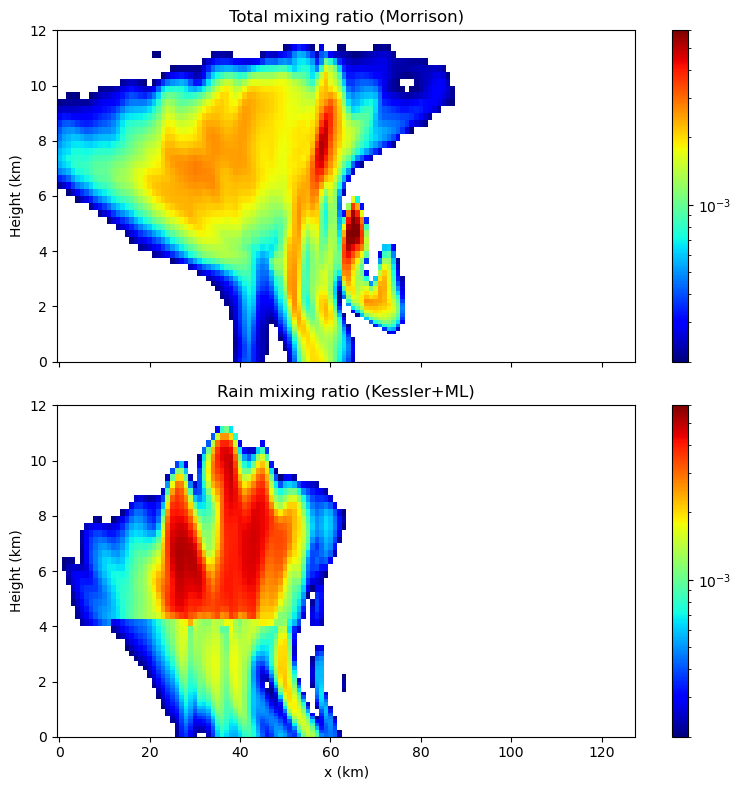

In [66]:
qtotm=np.ma.array(qtot,mask=qtot<0.0002)
qrkm=np.ma.array(qrk,mask=qrk<0.0002)
plt.figure(figsize=(8,8))
ax1=plt.subplot(2,1,1)
plt.title('Total mixing ratio (Morrison)')
plt.pcolormesh(range(128),z,qtotm[-2,:,10,:],cmap='jet',norm=matplotlib.colors.LogNorm(vmin=0.0002,vmax=0.006))
plt.ylim(0,12)
ax1.set_xticklabels([])
plt.ylabel('Height (km)')
plt.colorbar()
plt.subplot(2,1,2)
plt.title('Rain mixing ratio (Kessler+ML)')
plt.pcolormesh(range(128),z,qrkm[-2,:,10,:],cmap='jet',norm=matplotlib.colors.LogNorm(vmin=0.0002,vmax=0.006))
plt.colorbar()
plt.ylim(0,12)
plt.ylabel('Height (km)')
plt.xlabel('x (km)')
plt.tight_layout()
plt.savefig('hydrometeors.png')

In [87]:
with nc.Dataset('outputMorrison/squall_Morrison_ten.nc') as f:
    q3dten=f.variables['q3dten'][100::2,:]
    q3d=f.variables['q3d'][100::2,:]
    th3d=f.variables['th3d'][100::2,:]
    prs=f.variables['prs'][100::2,:]


In [88]:
q3dtot=q3d[:,:,:,:,1:6].sum(axis=-1)
q3dliq=q3d[:,:,:,:,1:3].sum(axis=-1)
a=np.nonzero(q3dtot>0.00001)
print(len(a[0]))
xL=[]
yL=[]
for it,i,j,k in zip(a[0],a[1],a[2],a[3]):
    xL.append([(th3d[it,i,j,k]-273.15)/30.,prs[it,i,j,k]/1e5,q3d[it,i,j,k,0]/4e-3,q3dtot[it,i,j,k]/1e-3])
    yL.append([q3dliq[it,i,j,k]/q3dtot[it,i,j,k],q3dten[it,i,j,k,0]/0.2e-4])

4508138


In [89]:
print(prs.max())

99621.125


In [90]:
xL=np.array(xL)
yL=np.array(yL)
print(xL.shape)
print(yL.mean(axis=0),yL.std(axis=0))
print(xL.mean(axis=0),xL.std(axis=0))   

(4508138, 4)
[ 0.27052427 -0.12311118] [0.41681205 0.99948064]
[-0.61873286  0.48195304  0.85313323  1.04650526] [0.8155492  0.23822639 1.00773695 1.42676916]


In [95]:
# train a neural network to predict the rain fraction. use a tensorflow network with 2 hidden layers with 10 nodes in each layer.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import models

def build_model():
    model = keras.Sequential([
        layers.Dense(10, activation='relu', input_shape=[4]),
        layers.Dense(10, activation='relu'),
        layers.Dense(2, activation=None)
    ])
    return model

mp_model = build_model()
#optimizer = tf.keras.optimizers.RMSprop(0.001)
mp_model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])



In [96]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(xL[::5], yL[::5], test_size=0.5, random_state=42)

history = mp_model.fit(x_train, y_train, epochs=50, validation_split = 0.2, verbose=1, batch_size=64,validation_data=(x_test,y_test))

Epoch 1/50
7044/7044 [==============================] - 5s 649us/step - loss: 0.2759 - mae: 0.1903 - mse: 0.2759 - val_loss: 0.2058 - val_mae: 0.1609 - val_mse: 0.2058
Epoch 2/50
7044/7044 [==============================] - 5s 640us/step - loss: 0.1815 - mae: 0.1510 - mse: 0.1815 - val_loss: 0.1651 - val_mae: 0.1434 - val_mse: 0.1651
Epoch 3/50
7044/7044 [==============================] - 5s 668us/step - loss: 0.1608 - mae: 0.1418 - mse: 0.1608 - val_loss: 0.1523 - val_mae: 0.1348 - val_mse: 0.1523
Epoch 4/50
7044/7044 [==============================] - 5s 642us/step - loss: 0.1542 - mae: 0.1390 - mse: 0.1542 - val_loss: 0.1495 - val_mae: 0.1347 - val_mse: 0.1495
Epoch 5/50
7044/7044 [==============================] - 5s 643us/step - loss: 0.1524 - mae: 0.1382 - mse: 0.1524 - val_loss: 0.1446 - val_mae: 0.1354 - val_mse: 0.1446
Epoch 6/50
7044/7044 [==============================] - 5s 674us/step - loss: 0.1503 - mae: 0.1372 - mse: 0.1503 - val_loss: 0.1482 - val_mae: 0.1362 - val_mse:

In [100]:
#y_=mp_model.predict(x_test)
print(np.corrcoef(y_test[:,0],y_[:,0]))
print(np.corrcoef(y_test[:,1],y_[:,1]))
mp_model.save('morrison_mp_model.keras')

[[1.         0.96143652]
 [0.96143652 1.        ]]
[[1.         0.88482871]
 [0.88482871 1.        ]]


In [102]:
print(x_test[0])
print(mp_model.predict(x_test[0:1]))

[-0.61198293  0.42765234  0.3781663   0.70211978]
1/1 [==============================] - 0s 12ms/step
[[0.00845625 0.12762249]]


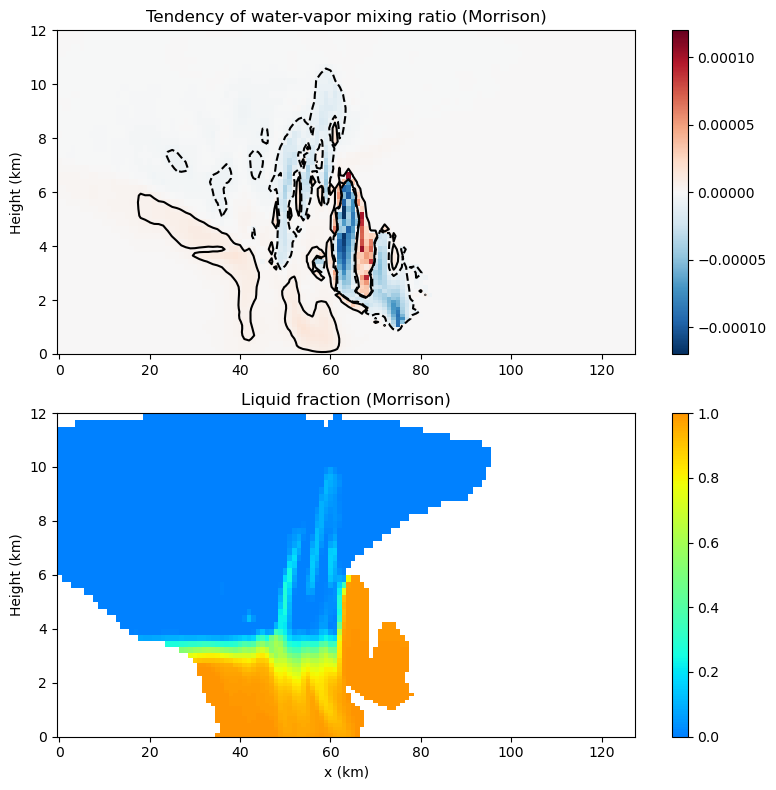

In [67]:

fract=np.ma.array(qliq/qtot,mask=qtot<0.0001)
plt.figure(figsize=(8,8))
plt.subplot(211)
c=plt.pcolormesh(range(128),z,q3dten[-2,:,10,:,0].T,cmap='RdBu_r',vmin=-0.00012,vmax=0.00012)
plt.contour(range(128),z,q3dten[-2,:,10,:,0].T,levels=[-0.000005],colors='k') 
plt.contour(range(128),z,q3dten[-2,:,10,:,0].T,levels=[0.000005],colors='k')    
cbar=plt.colorbar(c)
plt.ylim(0,12)
plt.ylabel('Height (km)')
plt.title("Tendency of water-vapor mixing ratio (Morrison)")
plt.subplot(212)
plt.pcolormesh(range(128),z,fract[-2,:,10,:],cmap='jet',vmin=-0.5,vmax=1.5)
plt.title("Liquid fraction (Morrison)")
cbar=plt.colorbar()
cbar.ax.set_ylim(-0.0,1.0)
plt.ylim(0,12)
plt.ylabel('Height (km)')
plt.xlabel('x (km)')
plt.tight_layout()
plt.savefig('diagnostics.png')